In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

# Load data from ai

In [3]:
df = pd.read_csv("C:/Users/CL9/OneDrive - Science Group/Desktop/SpxFlow/Condition monitoring datasets/ai4i2020.csv")

dataset = df[df["Type"]=="L"]
# dataset = df

# dataset = dataset[["Datetime","Air temperature [K]",	"Process temperature [K]",	"Rotational speed [rpm]",	"Torque [Nm]",	"Tool wear [min]",	"Machine failure"]]
dataset = dataset[["Datetime",	"Process temperature [K]",	"Rotational speed [rpm]",	"Torque [Nm]",	"Tool wear [min]"]]

In [4]:
dataset = dataset.set_index('Datetime').sort_index()
dataset.head()

,Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Datetime,,,,
2022-05-06 00:00:01,308.7,1408,46.3,3
2022-05-06 00:00:02,308.5,1498,49.4,5
2022-05-06 00:00:03,308.6,1433,39.5,7
2022-05-06 00:00:04,308.7,1408,40.0,9
2022-05-06 00:00:06,308.6,1558,42.4,14


<AxesSubplot:xlabel='Datetime'>

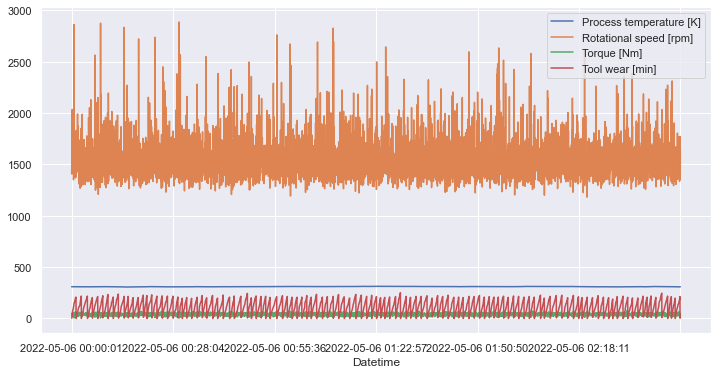

In [5]:
dataset.plot(figsize = (12,6))

In [32]:
dataset_train = dataset['2022-05-06 00:00:0':'2022-05-06 01:00:00']
dataset_test = dataset['2022-05-06 01:00:00':]
print(len(dataset_train),len(dataset_test))

2166 3835


In [34]:
dataset_test.head()

,Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Datetime,,,,
2022-05-06 01:00:00,310.5,1523,34.7,181
2022-05-06 01:00:01,310.5,1377,43.1,183
2022-05-06 01:00:03,310.7,1542,40.0,188
2022-05-06 01:00:04,310.8,1557,33.3,190
2022-05-06 01:00:05,310.7,1641,31.9,192


# Normalize data

In [35]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train),
                       columns=dataset_train.columns, 
                       index=dataset_train.index)

# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test),
                      columns=dataset_test.columns,  
                      index=dataset_test.index)

# PCA type model for anomaly detection

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [37]:
# Calculate the covariance matrix:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [38]:
# Calculate the Mahalanobis distance:

def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [39]:
# Detecting outliers:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [40]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [41]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [42]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [43]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [44]:
mean_distr = data_train.mean(axis=0)

In [45]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

In [46]:
print("MD Threshold is:",threshold)

MD Threshold is: 3.875351238633066


c:\Users\CL9\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



(0.0, 15.0)

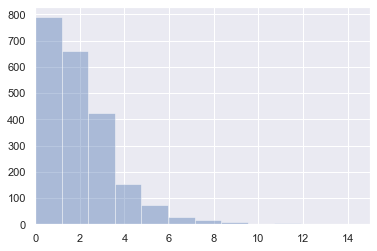

In [47]:
# Visualizing the square of the Mahalanobis distance, which should then ideally follow a χ2 distribution.

plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

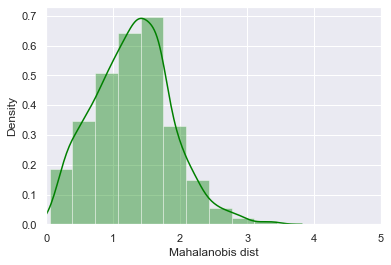

In [48]:
# Visualizing the distribution of the Mahalanobis distance

plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

From the above distributions, the calculated threshold value of 3.69 for flagging an anomaly seems reasonable (defined as 3 standard deviations from the center of the distribution)

In [49]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
Datetime,,,
2022-05-06 01:00:00,1.953053,3.875351,False
2022-05-06 01:00:01,1.849647,3.875351,False
2022-05-06 01:00:03,2.123961,3.875351,False
2022-05-06 01:00:04,2.291061,3.875351,False
2022-05-06 01:00:05,2.267178,3.875351,False


In [50]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata
# anomaly_alldata.to_csv('Anomaly_distance.csv')

,Mob dist,Thresh,Anomaly
Datetime,,,
2022-05-06 00:00:01,1.683372,3.875351,False
2022-05-06 00:00:02,1.689789,3.875351,False
2022-05-06 00:00:03,1.635134,3.875351,False
2022-05-06 00:00:04,1.592486,3.875351,False
2022-05-06 00:00:06,1.526062,3.875351,False
...,...,...,...
2022-05-06 02:46:28,1.576750,3.875351,False
2022-05-06 02:46:30,1.710810,3.875351,False
2022-05-06 02:46:32,1.654496,3.875351,False


<AxesSubplot:xlabel='Datetime'>

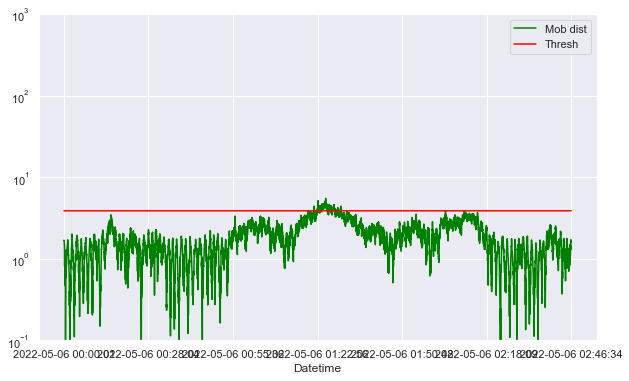

In [51]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])

In [52]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Machine Failure Test data",
    mode="lines", x=dataset_test.index, y=df[-6000:]["Machine failure"]
))

fig.add_trace(go.Scatter(
    name="Machine Failure Train data",
    mode="lines", x=dataset_train.index, y=df[-6000:]["Machine failure"]
))

fig.add_trace(go.Scatter(
    name="Mob distance on All data",
    mode="lines", x=anomaly_alldata.index, y=anomaly_alldata["Mob dist"]
))

fig.add_trace(go.Scatter(
    name="Threshold",
    mode="lines", x=anomaly_alldata.index, y=anomaly_alldata["Thresh"]
))

fig.update_layout(title_text="Actual Machine Failure")
fig.update_layout(
    legend=dict(
        x=0.01,
        y=0.95,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="price")
fig.show()